This is the third part in a series of notes on my exploration of the recently released [Google QuickDraw dataset](https://quickdraw.withgoogle.com/data), using the concurrently released [SketchRNN model][Ha2017]. 

Here are links to the [first](../exploring-the-google-quickdraw-dataset-with-sketchrnn-part-1/) and [second](../exploring-the-google-quickdraw-dataset-with-sketchrnn-part-2/) note.

---

The QuickDraw dataset is curated from the millions of drawings contributed by over 15 million people around the world who participated in the ["Quick, Draw!" A.I. Experiment](https://aiexperiments.withgoogle.com/quick-draw), in which they were given the challenge of drawing objects belonging to a particular class (such as "cat") in under 20 seconds.

SketchRNN is a very impressive generative model that was trained to produce vector drawings using this dataset. It was of particular interest to me because it cleverly combines many of the latest tools and techniques recently developed in machine learning, such as [Variational Autoencoders][Kingma2013], HyperLSTMs (a [HyperNetwork][Ha2016] for LSTM), [Autoregressive models][Reed2017], [Layer Normalization][Ba2016], [Recurrent Dropout][Semeniuta2016], the [Adam optimizer][Kingma2014], and others.

[Ha2017]: http://arxiv.org/abs/1704.03477 "D. Ha and D. Eck, 'A Neural Representation of Sketch Drawings,' Apr. 2017."
[Ha2016]: https://arxiv.org/abs/1609.09106 "D. Ha, A. Dai, and Q. V. Le, 'HyperNetworks,' Sep. 2016."
[Kingma2013]: https://arxiv.org/abs/1312.6114 "D. P. Kingma and M. Welling, 'Auto-Encoding Variational Bayes,' Dec. 2013."
[Reed2017]: https://arxiv.org/abs/1703.03664 "S. Reed et al., 'Parallel Multiscale Autoregressive Density Estimation,' Mar. 2017."
[Semeniuta2016]: https://arxiv.org/abs/1603.05118 "S. Semeniuta, A. Severyn, and E. Barth, 'Recurrent Dropout without Memory Loss,' Mar. 2016."
[Ba2016]: https://arxiv.org/abs/1607.06450 "J. L. Ba, J. R. Kiros, and G. E. Hinton, 'Layer Normalization,' Jul. 2016."
[Kingma2014]: https://arxiv.org/abs/1412.6980 "D. P. Kingma and J. Ba, 'Adam: A Method for Stochastic Optimization,' Dec. 2014."

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import tensorflow as tf

from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib import rc

from sklearn.decomposition import PCA

from itertools import product
from six.moves import map, zip

In [3]:
from magenta.models.sketch_rnn.sketch_rnn_train import \
    (load_env,
     load_checkpoint,
     reset_graph,
     download_pretrained_models,
     PRETRAINED_MODELS_URL)
from magenta.models.sketch_rnn.model import Model, sample
from magenta.models.sketch_rnn.utils import (lerp,
                                             slerp,
                                             get_bounds, 
                                             to_big_strokes,
                                             to_normal_strokes)

In [4]:
# For inine display of animation
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [5]:
# set numpy output to something sensible
np.set_printoptions(precision=8, 
                    edgeitems=6, 
                    linewidth=200, 
                    suppress=True)

In [6]:
tf.logging.info("TensorFlow Version: {}".format(tf.__version__))

INFO:tensorflow:TensorFlow Version: 1.1.0


### Getting the Pre-Trained Models and Data

In [7]:
DATA_DIR = ('http://github.com/hardmaru/sketch-rnn-datasets/'
            'raw/master/aaron_sheep/')
MODELS_ROOT_DIR = '/tmp/sketch_rnn/models'

In [8]:
DATA_DIR

'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'

In [9]:
PRETRAINED_MODELS_URL

'http://download.magenta.tensorflow.org/models/sketch_rnn.zip'

In [10]:
download_pretrained_models(
    models_root_dir=MODELS_ROOT_DIR,
    pretrained_models_url=PRETRAINED_MODELS_URL)

INFO:tensorflow:/tmp/sketch_rnn/models/sketch_rnn.zip already exists, using cached copy
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


We look at the layer normalized model trained on the `aaron_sheep` dataset for now.

In [11]:
MODEL_DIR = MODELS_ROOT_DIR + '/aaron_sheep/layer_norm'

In [12]:
(train_set, 
 valid_set, 
 test_set, 
 hps_model, 
 eval_hps_model, 
 sample_hps_model) = load_env(DATA_DIR, MODEL_DIR)

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz
INFO:tensorflow:Loaded 7400/300/300 from aaron_sheep.npz
INFO:tensorflow:Dataset combined: 8000 (7400/300/300), avg len 125
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.


In [13]:
class SketchPath(Path):
    
    def __init__(self, data, factor=.2, *args, **kwargs):
        
        vertices = np.cumsum(data[::, :-1], axis=0) / factor
        codes = np.roll(self.to_code(data[::,-1].astype(int)), 
                        shift=1)
        codes[0] = Path.MOVETO

        super(SketchPath, self).__init__(vertices, 
                                         codes, 
                                         *args, 
                                         **kwargs)
        
    @staticmethod
    def to_code(cmd):
        # if cmd == 0, the code is LINETO
        # if cmd == 1, the code is MOVETO (which is LINETO - 1)
        return Path.LINETO - cmd

In [14]:
def draw(sketch_data, factor=.2, pad=(10, 10), ax=None):

    if ax is None:
        ax = plt.gca()

    x_pad, y_pad = pad
    
    x_pad //= 2
    y_pad //= 2
        
    x_min, x_max, y_min, y_max = get_bounds(data=sketch_data,
                                            factor=factor)

    ax.set_xlim(x_min-x_pad, x_max+x_pad)
    ax.set_ylim(y_max+y_pad, y_min-y_pad)

    sketch = SketchPath(sketch_data)

    patch = patches.PathPatch(sketch, facecolor='none')
    ax.add_patch(patch)

### Load pre-trained models

In [15]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.


In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [17]:
# loads the weights from checkpoint into our model
load_checkpoint(sess=sess, checkpoint_path=MODEL_DIR)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector


In [18]:
def encode(input_strokes):
    strokes = to_big_strokes(input_strokes).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    z = sess.run(eval_model.batch_z,
                 feed_dict={
                    eval_model.input_data: [strokes], 
                    eval_model.sequence_lengths: seq_len})[0]
    return z

In [19]:
def decode(z_input=None, temperature=.1, factor=.2):
    z = None
    if z_input is not None:
        z = [z_input]
    sample_strokes, m = sample(
        sess, 
        sample_model, 
        seq_len=eval_model.hps.max_seq_len, 
        temperature=temperature, z=z)
    return to_normal_strokes(sample_strokes)

### Principal Component Analysis of the Latent Space

> What do you call a baby eigensheep? A lamb, duh.

In [22]:
Z = np.vstack(map(encode, test_set.strokes))
Z.shape

(300, 128)

In [24]:
pca = PCA(n_components=2)

In [25]:
pca.fit(Z)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [27]:
Z_pca = pca.transform(Z)
Z_pca.shape

(300, 2)

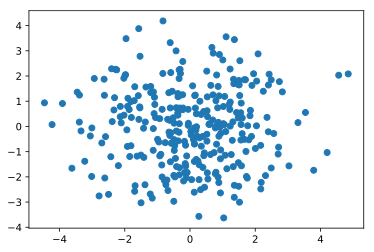

In [28]:
fig, ax = plt.subplots()

ax.scatter(*Z_pca.T)

plt.show()

In [45]:
pc1_min, pc2_min = np.amin(Z_pca, axis=0)
pc1_max, pc2_max = np.amax(Z_pca, axis=0)

In [55]:
pc1 = lerp(pc1_min, pc1_max, np.linspace(0, 1, 10))

In [59]:
pc2 = lerp(pc2_min, pc2_max, np.linspace(0, 1, 10))

In [60]:
pc1_mesh, pc2_mesh = np.meshgrid(pc1, pc2)

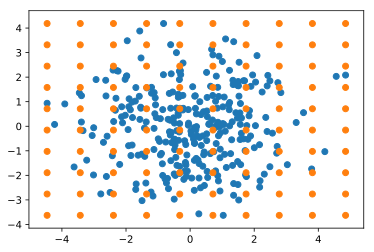

In [61]:
fig, ax = plt.subplots()

ax.scatter(*Z_pca.T)
ax.scatter(pc1_mesh, pc2_mesh)

plt.show()

In [62]:
np.dstack((pc1_mesh, pc2_mesh)).shape

(10, 10, 2)

In [64]:
z_grid = np.apply_along_axis(pca.inverse_transform,  
                             arr=np.dstack((pc1_mesh, pc2_mesh)),
                             axis=2)
z_grid.shape

(10, 10, 128)

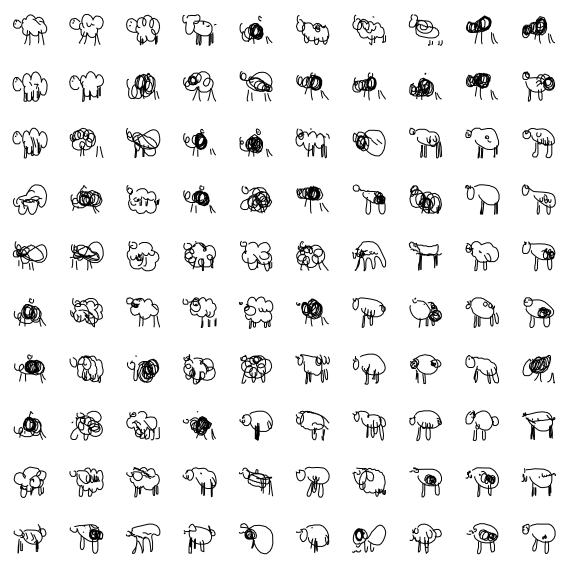

In [69]:
fig, ax_arr = plt.subplots(nrows=10, 
                           ncols=10, 
                           figsize=(8, 8),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for i, ax_row in enumerate(ax_arr):    
    for j, ax in enumerate(ax_row):
        draw(decode(z_grid[i,j], temperature=.1), ax=ax)
        ax.axis('off')

plt.show()

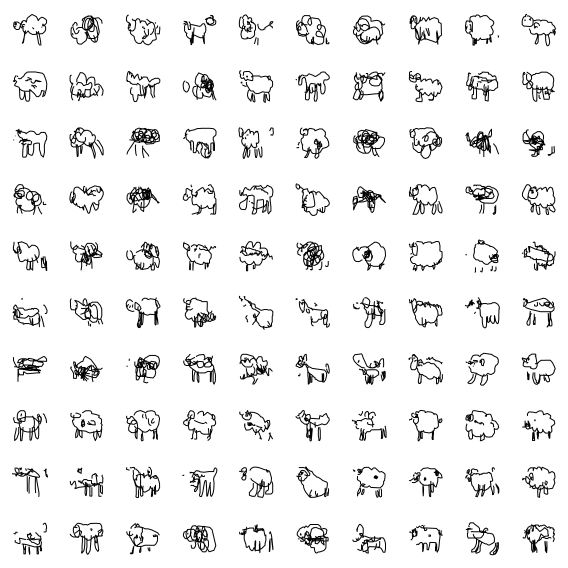

In [68]:
fig, ax_arr = plt.subplots(nrows=10, 
                           ncols=10, 
                           figsize=(8, 8),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for i, ax_row in enumerate(ax_arr):    
    for j, ax in enumerate(ax_row):
        draw(decode(z_grid[i,j], temperature=.6), ax=ax)
        ax.axis('off')

plt.show()

### Eigensheep Decomposition

In [75]:
z_pc1, z_pc2 = pca.components_

In [76]:
pca.explained_variance_ratio_

array([ 0.0216283 ,  0.02038656])

In [77]:
pca.explained_variance_

array([ 2.5252845,  2.3803008])

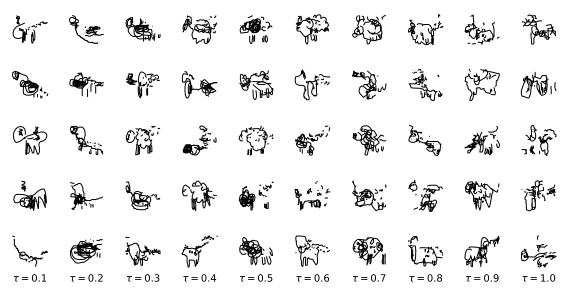

In [79]:
fig, ax_arr = plt.subplots(nrows=5, 
                           ncols=10, 
                           figsize=(8, 4),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for row_num, ax_row in enumerate(ax_arr):    
    for col_num, ax in enumerate(ax_row):
        t = (col_num + 1) / 10.
        draw(decode(z_pc1, temperature=t), ax=ax)

        if row_num + 1 == len(ax_arr):
            ax.set_xlabel(r'$\tau={}$'.format(t))
        
plt.show()

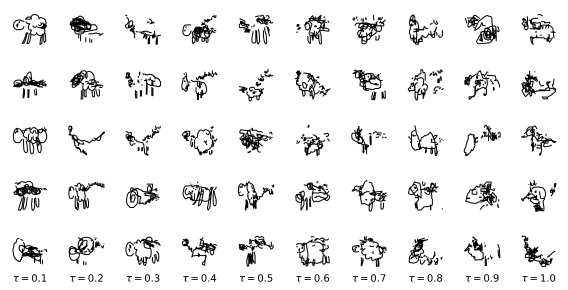

In [80]:
fig, ax_arr = plt.subplots(nrows=5, 
                           ncols=10, 
                           figsize=(8, 4),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for row_num, ax_row in enumerate(ax_arr):    
    for col_num, ax in enumerate(ax_row):
        t = (col_num + 1) / 10.
        draw(decode(z_pc2, temperature=t), ax=ax)

        if row_num + 1 == len(ax_arr):
            ax.set_xlabel(r'$\tau={}$'.format(t))
        
plt.show()

### t-SNE Visualization

In [81]:
from sklearn.manifold import TSNE

In [82]:
tsne = TSNE(n_components=2, n_iter=5000)

In [83]:
Z_tsne = tsne.fit_transform(Z)

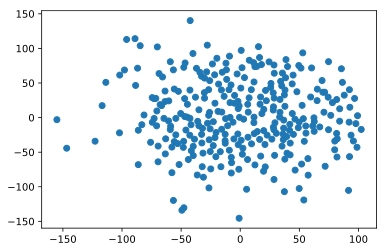

In [84]:
fig, ax = plt.subplots()

ax.scatter(*Z_tsne.T)

plt.show()

In [89]:
tsne.kl_divergence_

2.137801170349121

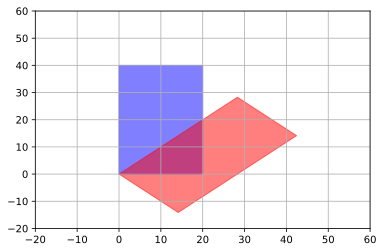

In [249]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_subplot(111)

r1 = patches.Rectangle((0,0), 20, 40, color="blue", alpha=0.50)
r2 = patches.Rectangle((0,0), 20, 40, color="red",  alpha=0.50)

t2 = mpl.transforms.Affine2D().rotate_deg(-45) + ax.transData
r2.set_transform(t2)

ax.add_patch(r1)
ax.add_patch(r2)

plt.xlim(-20, 60)
plt.ylim(-20, 60)

plt.grid(True)

plt.show()

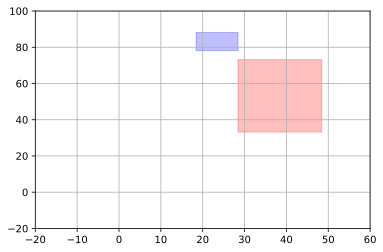

In [262]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as collections
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim(-20, 60)
ax.set_ylim(-20, 100)

p = []

p.append(patches.Rectangle((0, 0), 20, 40))
p.append(patches.Rectangle((0, 0), 10, 10))

collection = collections.PatchCollection(p,
                                         offsets=np.array([[0, 0], 
                                                           [-10, 45]]),
                                         transOffset=ax.transData)
collection.set_color(('red','blue'))
collection.set_alpha(.25)

ax.add_collection(collection)

ax.grid(True)


plt.show()

In [259]:
ax.transLimits.transform((-20, 100))

array([ 0.,  1.])

In [212]:
collection.get_offsets()

array([[  0,   0],
       [-10,  50]])

In [99]:
fig.dpi_scale_trans

Affine2D(array([[ 72.,   0.,   0.],
       [  0.,  72.,   0.],
       [  0.,   0.,   1.]]))

In [104]:
mpl.transforms.Affine2D().scale(72.)

Affine2D(array([[ 72.,   0.,   0.],
       [  0.,  72.,   0.],
       [  0.,   0.,   1.]]))

In [112]:
ax.transScale.get_matrix()

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [113]:
ax.transData.get_matrix()

array([[   4.185,    0.   ,  137.7  ],
       [   0.   ,    2.718,   90.36 ],
       [   0.   ,    0.   ,    1.   ]])

In [114]:
ax.transLimits.get_matrix()

array([[ 0.0125,  0.    ,  0.25  ],
       [ 0.    ,  0.0125,  0.25  ],
       [ 0.    ,  0.    ,  1.    ]])

In [304]:
sketch1 = test_set.random_sample()
sketch2 = test_set.random_sample()

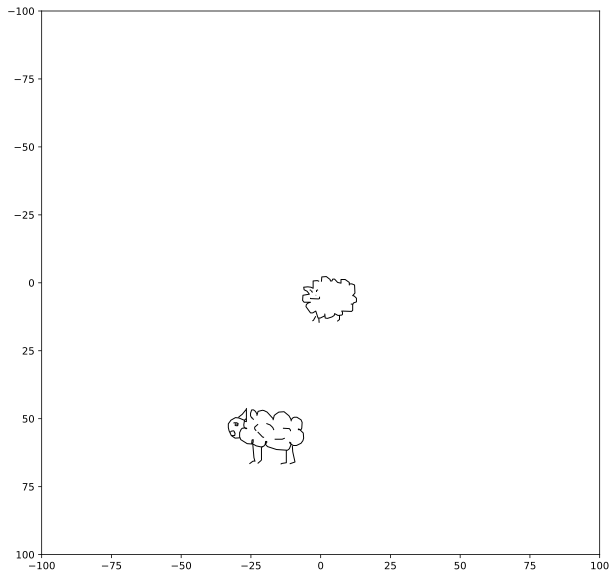

In [315]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(-100, 100)
ax.set_ylim(100, -100)

sketch_path1 = SketchPath(sketch1, factor=.4)
patch1 = patches.PathPatch(sketch_path1, facecolor='none')
ax.add_patch(patch1)

sketch_path2 = SketchPath(sketch2, factor=.4)
sketch_path2.vertices += np.array([-25., 50.])

patch2 = patches.PathPatch(sketch_path2, facecolor='none')
ax.add_patch(patch2)

plt.show()

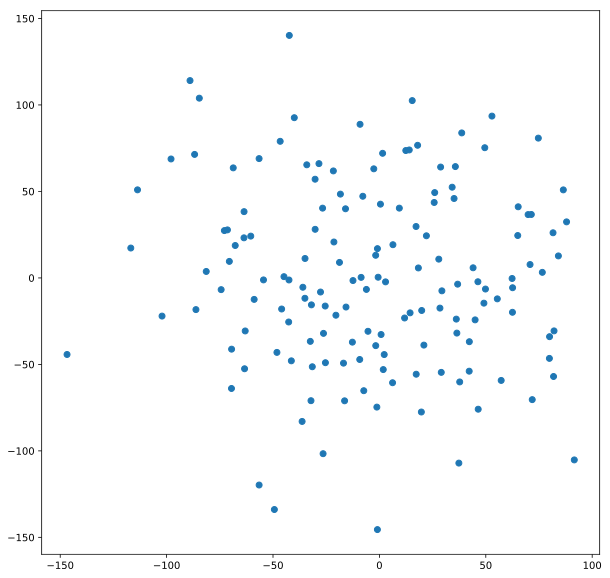

In [317]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(*Z_tsne[::2].T)

plt.show()

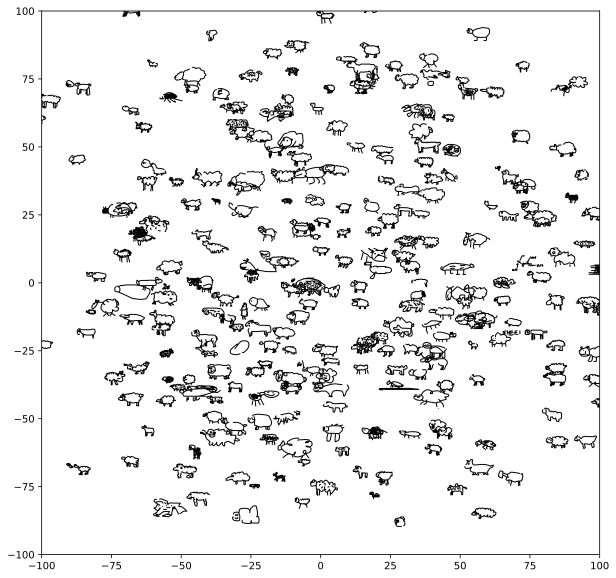

In [351]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)

for i, sketch in enumerate(test_set.strokes):
    sketch_path = SketchPath(sketch, factor=1.8)
    sketch_path.vertices[::,1] *= -1
    sketch_path.vertices += Z_tsne[i]
    patch = patches.PathPatch(sketch_path, facecolor='none')
    ax.add_patch(patch)

plt.savefig("../../files/tsne.svg", format="svg")

In [352]:
from IPython.display import SVG, FileLink

In [356]:
FileLink('../../../tsne.svg')

/media/tiao/Data/Dropbox/Projects/tsne.svg